# Topics Covered

- What does Encoder do?
- What is Self Attention
- Machine Learning enhanced Self Attention
- Masking in Self Attention

# Dependencies

In [1]:
import numpy as np
import pandas as pd
import sentencepiece as spm
import torch
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Introduction

In the last chapter, I discussed dataset in great detail. Starting from  the raw strings, we saw how it is preprocessed into a sequence of integer tokens. These tokens are then fed into token embedding where each integer is mapped to a high dimensional vector (with some sense of language semantics). Finally, positional encoding adds the information related to the position of each token in the sequence. This was important because unlike Recurrent Neural Nets, Transformers accept and operate on the complete sequence in parallel.

In this chapter, I will spend some time discussing self attention. Starting from the very basic intuition of the operations behind self attention, I will build an Encoder network which processes the input shakespeare sentences and understand the context between different tokens.

# What is Attention

The purpose of Attention is to assign a "similarity score" between tokens in sequences. Let me explain this using a very simple example. Consider a sequence containing 5 different movies. Each movie has 3 attributes (comedy, adventure and animated) which can take values from -1 to 1. For instance, movie 1 is pure comedy so it's attributes would be something like [1, -1, -1]. However, another movie is animated with adventure and a bit of comedy. The attribute values in this case would look something like [0.2, 0.8, 1]. Similarly we have attribute values assigned to rest of the movies. The task here is to recommend movies to 3 different users with different movie preferences. Similar to the movies, these users can also be put into a sequence with attribute values representing their movie preferences.

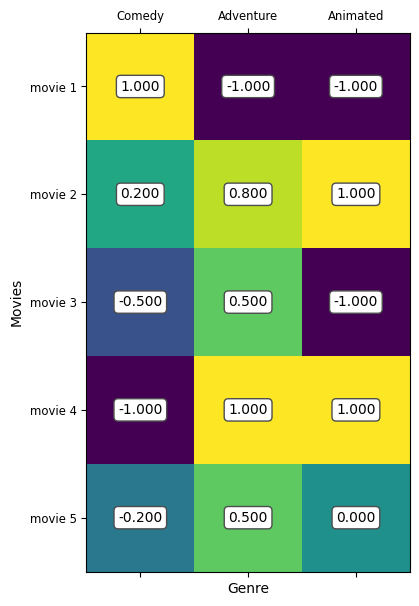

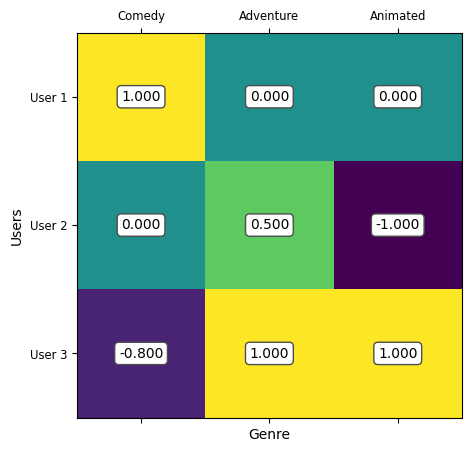

In [12]:
movies = np.array([[1, -1, -1],
                  [0.2, 0.8, 1],
                  [-0.5, 0.5, -1],
                  [-1, 1, 1],
                  [-0.2, 0.5, 0]])

plt.rcParams["figure.figsize"] = (5,7)
fig, ax = plt.subplots()
im = ax.matshow(movies)
text_objects = []
for (i, j), z in np.ndenumerate(movies):
    text = ax.text(j, i, '{:0.3f}'.format(z), ha='center', va='center',
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'), color="black")
    text_objects.append(text)
ax.set_yticks(range(movies.shape[0]), ["movie 1", "movie 2", "movie 3", "movie 4", "movie 5"], size='small')
ax.set_xticks(range(movies.shape[1]), ["Comedy", "Adventure", "Animated"], size='small')
ax.set_ylabel("Movies")
ax.set_xlabel("Genre")
plt.show()

users = np.array([[1, 0, 0],
                  [0, 0.5, -1],
                  [-0.8, 1, 1]])
plt.rcParams["figure.figsize"] = (5,5)
fig, ax = plt.subplots()
im = ax.matshow(users)
text_objects = []
for (i, j), z in np.ndenumerate(users):
    text = ax.text(j, i, '{:0.3f}'.format(z), ha='center', va='center',
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'), color="black")
    text_objects.append(text)
ax.set_yticks(range(users.shape[0]), ["User 1", "User 2", "User 3"], size='small')
ax.set_xticks(range(users.shape[1]), ["Comedy", "Adventure", "Animated"], size='small')
ax.set_ylabel("Users")
ax.set_xlabel("Genre")
plt.show()


How can we mathematically evaluate which user will like which movie more? The Answer is dot product!

If we premultiply the users matrix with the transpose of the movies matrix (i.e. match the attribute values in users against movies), we will get a score telling us how much a given user might like a movie.

```py
# Dot product between Users and Movie
score = users @ movies.T
```

This `score` could be any floating point number. It could end up being a very large number if there are more attribute values, so it's better to scale this by the square root of number of attributes (3 in this case). 

> Why $\sqrt{3}$? Its the Euclidean length of the vectors in the sequence. Therefore, we are dividing out the amount by which the increase in dimension increases the length of the average vectors.

```py
# Scaling down the score
score = score / (3**(1/2))
```

Now the score is scaled nicely and won't blow up as the number of attributes increase, but it would still be better to have this number between 0 and 1. This is done by applying row wise softmax to the score matrix. 

> Why row wise softmax? We want to analyse how a user would like different movies, hence scores across a set user need to sum up to 1.

```py
# Row wise Softmax
score = F.softmax(score, dim=-1)
```

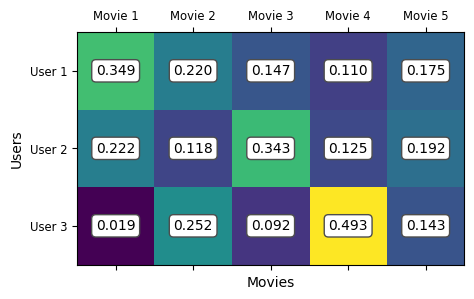

In [16]:
# Dot Product
score = users @ movies.T
# Scaling
score = score / (len(users)**(1/2))
# Row wise Softmax
score = F.softmax(torch.tensor(score), dim=-1).numpy()

plt.rcParams["figure.figsize"] = (5,5)
fig, ax = plt.subplots()
im = ax.matshow(score)
text_objects = []
for (i, j), z in np.ndenumerate(score):
    text = ax.text(j, i, '{:0.3f}'.format(z), ha='center', va='center',
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'), color="black")
    text_objects.append(text)
ax.set_yticks(range(score.shape[0]), ["User 1", "User 2", "User 3"], size='small')
ax.set_xticks(range(score.shape[1]), ["Movie 1", "Movie 2", "Movie 3", "Movie 4", "Movie 5"], size='small')
ax.set_ylabel("Users")
ax.set_xlabel("Movies")
plt.show()

# Adding Machine Learning to Self Attention

This concept can be applied straight to out dataset. 